# project name

joe
dave

TODO: 
1. we tried shortening the board height
1. explain that time and overhangs were not implemented
1. tell reader what's in each section at the beginning of the section
1. Instructions for playing the animation on the console
1. Yiyuan Lee had very good results.  He used a random generator that prevents long sequences of S/Z pieces.

# abstract/intro
what, why, brief overview of methods and results

2-4 paragraphs

# methods
Here are the steps that we took:
1. Build a simple tetris clone that outputs using stdout.
1. Make a random-placment AI that places the pieces in a random column with a random rotation.
1. Make an AI that searches all valid moves in a single game state, and chooses the move that puts the piece at the lowest possible position.
1. Make a reinforcement learning AI with a neural network for the Q table.  We didn't try to do reinforcement learning with a normal Q table because we thought it would use too much ram to be useful.  This first AI used column heights as part of the input to the neural network.
1. Tune the AI's parameters for best learning.
1. Change the neural network to use the entire board as input instead of just the column heights.  Surprisingly, this seemed to work better.
1. Make an AI that searches all valid moves in a single game state, and uses a combination of piece placment height and number of "holes" in each board to choose the best move.
1. Tune the parameters for that AI.

steps taken, resources used (code, papers, [Russell and Norvig, 2014], ...)

intermediate results 

what each team member did (or its own section)

We wrote a play_game function that plays a single game of Tetris with this signature: ``play_game(self, strategyF, display=False, sleep=None)``.  The strategyF is a function that takes in a board and returns the best move for that board.  Display is whether or not to output the colorized tetris board to stdout, and sleep is a value for how long to wait between making moves (if you want to watch a game as it is being played).

In [1]:
import tetris
import ai
import importlib
import numpy as np

Here is an example of a game being played with randomly chosen moves.

In [2]:
tetris.Board().play_game(ai.randomMoveStrategy, True)

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

26

Here's the minimum height strategy.  It goes through all valid moves and picks the move with the lowest y position.  In the case of a tie, it chooses the first (i.e. leftmost) move.

In [3]:
tetris.Board().play_game(ai.minHeightStrategy, True)

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

48

And, here's the strategy that uses a combination of minimum height and number of holes.  This strategy had the best performance out of any strategy we tried.

In [4]:
tetris.Board().play_game(ai.holesAndHeightStrategy, True)

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|  |
|                    |
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|                    |
|_|_|_|_|_|_|_|_|_|  |
+---------


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|_|      |
|  _|_|_|  _|_|  _|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|    |
|  _|_|_|  _|_|_|    |
|  _|_|_|_|_|_|_|  _||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_|

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|              _|_|  |
|      _|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|              _|_|  |
|      _|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|                    |
|                    |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|          _|  |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|    _|_|  _|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|  _|_|_|        _|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|        _|_|  |
|  _|_|_|    _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|  _|_|              |
|  _|_|      _|_|_|  |
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|  _|_|        _|_|_||
|  _|_|      _|_|_|_||
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|    _|_|            |
|_|  _|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|    _|_|          _||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|    _|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|_|            |
|  _|_|_|  _|    _|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                  _||
|        _|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|    _|_|          _||
|    _|_|_|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|  _|_|          |
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|  _|_|          |
|_|_|  _|_|_|_|_|_|_||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|  _|    _|      _|  |
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|              _|    |
|  _|    _|_|_|_|_|  |
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|_|  _|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|  _|_|_|            |
|  _|_|_|_|_|_|  _|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|    _|    |
|  _|_|_|_|  _|_|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|    _|_|_||
|  _|_|_|_|  _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|_|  _|_|_|  _|  |
|_|_|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|        _|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|      _|_|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|  _|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|            _|      |
|      _|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|  _|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|            _||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                _|_||
|_|_|_|        _|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|    _|  |
|_|_|    _|_|  _|_|  |
|_|_|    _|_|_|_|_|_||
|_|_|_|  _|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|    _|  |
|_|_|  _|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|      _|_|_|  |
|_|_|_|    _|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|      _|            |
|_|_|_|_|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|              |
|_|_|_|  _|_|  _|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|_|        |
|_|_|_|  _|_|        |
|_|_|_|  _|_|  _|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|_|  _|_|      |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|_|  |
|  _|_|_|  _|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|        _|  |
|    _|_|_|      _|_||
|    _|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|    _|  |
|    _|_|_|_|_|  _|_||
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|      _|    _|_|_|  |
|  _|_|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|            _|_|    |
|            _|_|_|  |
|      _|    _|_|_|  |
|  _|_|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|        _|_|        |
|      _|_|_|_|_|    |
|    _|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|  _|    _|_|        |
|  _|_|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|    _|_|            |		_|_|_|_|
|    _|_|            |		        
|    _|_|_|    _|    |		        
|    _|_|_|  _|_|_|_||		        
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|    _|_|            |
|    _|_|            |
|    _|_|_|    _|    |
|    _|_|_|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|  _|  _|_|  _|      |
|  _|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|  _|  _|_|  _|      |
|  _|_|_|_|  _|_|_|_||
|                    |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|    _|    _|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|    _|    _|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|                    |
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|  _|            |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|          |
|  _|  _|_|_|        |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|    _|              |
|  _|_|_|_|_|        |
|_|_|_|_|_|_|_|  _|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|    _|          _|  |
|  _|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|          |
|  _|    _|_|        |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|_|          |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|_|_|        _|_|    |
|_|_|        _|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|_|_|  _|    _|_|    |
|_|_|  _|_|  _|_|    |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|    _|  _|_|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|    _|  _|_|_|    _||
|_|_|_|_|  _|_|_|  _||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|            _|    |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|            _|    |
|_|  _|_|_|_|_|_|_|_||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|    |
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|    _|_|            |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|    _|_|            |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------


+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|  _|    _|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|  _|  _|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|          _|_|_|    |
|_|_|      _|_|_|    |
|_|_|      _|_|_|    |
|_|_|  _|  _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|          _|_|_|    |
|_|_|      _|_|_|    |
|_|_|      _|_|_|    |
|_|_|  _|  _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|  _|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|_|    _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|_|    _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|  _|_|      |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                  _||
|                  _||
|      _|  _|_|    _||
|_|_|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|      _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|      _|_|_|  |
|                    |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|_|_|    |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                _|  |
|              _|_|  |
|  _|_|    _|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|          _|        |		        
|          _|_|      |		        
|  _|_|  _|_|_|      |
|  _|_|  _|_|_|      |
|  _|_|  _|_|_|  _|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|          _|        |		        
|          _|_|      |		        
|  _|_|  _|_|_|  _|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

379

The play_ai_game() method trains the reinforcement-learning-with-neural-network-as-Q-table AI using parameters hardcoded in ai.py.  It then uses the trained AI to play one game that it displays.

In [5]:
ai.play_ai_game(100, [100]*40, 1, .98, 1, 1)

Played game 0 , lasted for 24 moves, epsilon is 1
Played game 1 , lasted for 25 moves, epsilon is 0.98
Played game 2 , lasted for 26 moves, epsilon is 0.9603999999999999
Played game 3 , lasted for 24 moves, epsilon is 0.9411919999999999
Played game 4 , lasted for 24 moves, epsilon is 0.9223681599999999
Played game 5 , lasted for 20 moves, epsilon is 0.9039207967999998
Played game 6 , lasted for 19 moves, epsilon is 0.8858423808639998
Played game 7 , lasted for 27 moves, epsilon is 0.8681255332467198
Played game 8 , lasted for 29 moves, epsilon is 0.8507630225817854
Played game 9 , lasted for 25 moves, epsilon is 0.8337477621301497
Played game 10 , lasted for 28 moves, epsilon is 0.8170728068875467
Played game 11 , lasted for 24 moves, epsilon is 0.8007313507497957
Played game 12 , lasted for 28 moves, epsilon is 0.7847167237347998
Played game 13 , lasted for 25 moves, epsilon is 0.7690223892601038
Played game 14 , lasted for 28 moves, epsilon is 0.7536419414749017
Played game 15 , last

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|    _|              |
|    _|              |
|  _|_|              |
|  _|_|              |
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|              |

+--------------------+
|  _|_|_|            |		  _|    
|  _|_|_|            |		_|_|    
|  _|_|              |		  _|    
|  _|_|              |		        
|  _|                |
|  _|                |
|  _|_|_|            |
|    _|              |
|  _|_|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|              |
|    _|            _||
|  _|_|  _|_|_|  _|_||
|  _|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		_|_|_|_|
|  _|_|_|            |		        
|  _|_|              |		        
|  _|_|              |		        
|  _|                |
|  _|                |
|  _|_|_|            |
|    _|              |
|  _|_|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|  _|_|_|      |

+--------------------+
|  _|_|_|            |		_|_|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|          |
|    _|  _|          |
|  _|_|  _|_|_|      |
|  _|_|    _|        |
|  _|_|    _|        |
|    _|  _|_|        |
|  _|_|  _|          |
|  _|_|  _|_|        |
|    _|    _|        |
|  _|_|    _|        |
|_|  _|  _|_|_|      |
|_|  _|    _|      _||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		_|_|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|          |
|    _|  _|          |
|  _|_|  _|_|_|      |
|  _|_|    _|        |
|  _|_|    _|        |
|    _|  _|_|        |
|  _|_|  _|          |
|  _|_|  _|_|        |
|    _|    _|        |
|  _|_|    _|        |
|_|  _|  _|_|_|_|_|  |

+--------------------+
|  _|_|_|            |		  _|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		  _|    
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|  _|_|  _|      _|_||
|  _|_|  _|_|    _|_||
|    _|    _|    _|_||
|  _|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |
|_|  _|    _|  _|_|_||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		    _|  
|  _|_|_|_|_|        |		_|_|_|  
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|    _|_|_||
|  _|    _|      _|  |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|  _|_|  _|      _|_||
|  _|_|  _|_|    _|_||
|    _|    _|    _|_||
|  _|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |

+--------------------+
|  _|_|_|  _|_|_|    |		        
|  _|_|_|_|_|_|  _|_||		        
|  _|_|  _|  _|_|  _||		        
|  _|_|  _|  _|_|  _||		        
|  _|    _|    _|_|_||
|  _|    _|      _|  |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|_|_|_|  _|      _|_||
|_|_|_|  _|_|    _|_||
|_|  _|    _|    _|_||
|_|_|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |
|_|  _|    _|  _|_|_||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

28 moves


# results
show all results - 

graphs, etc

We tried the train method with a variety of parameters.  We found (surprisingly!) that the best number of training iterations and replays was 1 and 1.  If we increased either past 1, the training speed (in terms of performance per time spent training, not in terms of performance per number of games played) seemed to get worse.  We ran the train method for 50,000 games with 1 training iteration, 1 replay, epsilon decay factor .999, and ``[50, 20, 10, 2, 10, 20, 50]`` as the hidden layers. This took several hours to run.  We saved the game lengths into a file:

In [6]:
import numpy as np
game_lengths = np.loadtxt("ai-game-lengths.txt")
len(game_lengths), max(game_lengths), min(game_lengths), sum(game_lengths)/len(game_lengths)

(50000, 55.0, 14.0, 31.0518)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

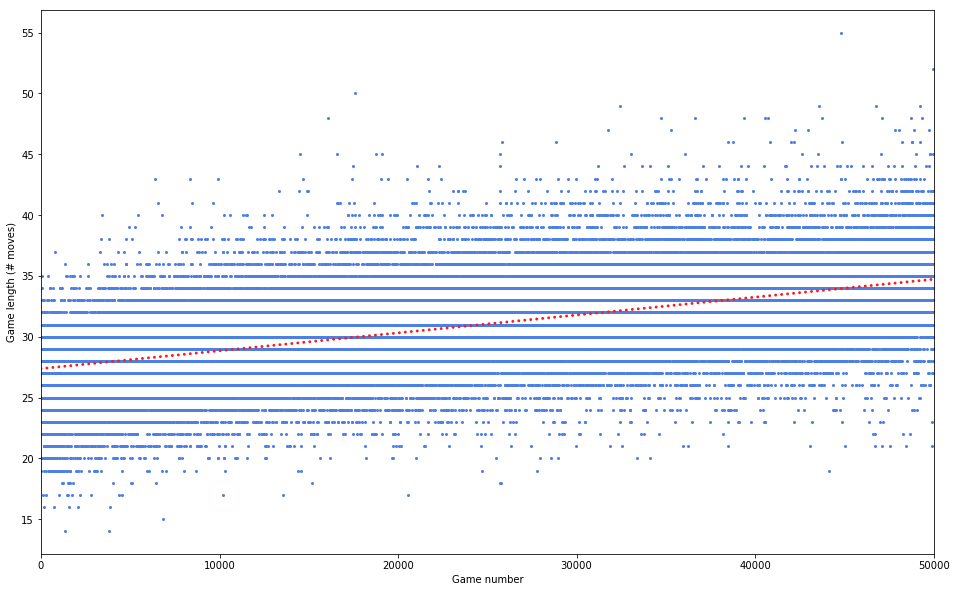

In [8]:
plt.figure(figsize=(16,10))
plt.margins(0, .045)
plt.ylabel("Game length (# moves)")
plt.xlabel("Game number")
plt.plot(game_lengths, '.', ms=4, color=(.3, .5, .9));

# Add a trendline to the graph
p = np.poly1d(np.polyfit(range(len(game_lengths)), game_lengths, 1))
plt.plot(p(range(len(game_lengths))),"--", dashes=(.001, 2), lw=3, color=(1, .1, .1), dash_capstyle="round");

As you can see, the game lengths did increase as the number of games played increased, but there wasn't a significant change.  It should be possible for the AI to play very long games (over 1000 moves), but the longest game we saw was 55 moves.  Perhaps if we continued to train it it would continue to improve.  When we watched the trained AI play a game, it effectively filled the board with pieces, but it didn't fill very many lines (it did fill some!).  It could be that it learned that filling the space more effectively leads to longer games, but it didn't yet learn that getting lines leads to longer games, or how to get lines.

When we ran the AI with just "I" and "O" pieces (the long piece and the square piece), it did get some very long games (>300 lines).  When we watched those games, it filled the board with pieces, and then started getting lines near the top of the board.  Perhaps with more training time, it could learn to get lines lower, instead of higher up.

Since the AI was taking so long to train, we decided to go back to simple greedy strategies.  We tried a strategy that tries every valid move, counts the number of holes in the board, and balances that against the height the piece is placed at.  Lower is better, and fewer holes are better.  This strategy seemed to work quite well (we got game lengths over 300 moves), so we decided to try to tune it for maximum performance.

For tuning the holesAndHeightStrategy, we tried playing a set of games with different balance factors.  For each balance factor, we played 30 games, and collected the minimum, maximum, and average game lengths.  (It took about 52 minutes to run.)

numGames, factor, min, max, avg



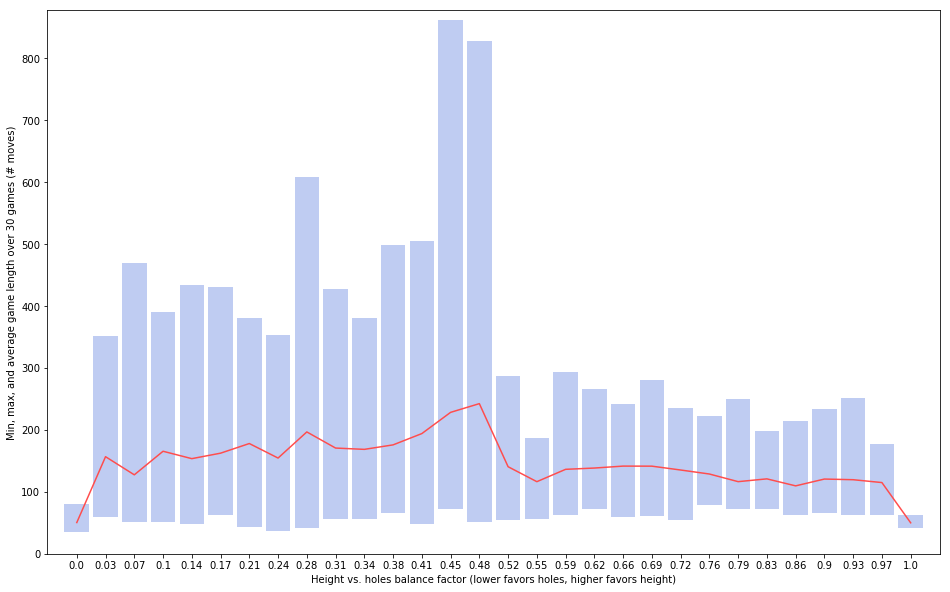

In [9]:
with open("holes-and-height-scan-0-1.txt") as f:
    firstLine = f.readline()
    print(firstLine)
    data = np.loadtxt(f,delimiter=",")
X = data[:,1]
avg = data[:,4]
mins = data[:,2]
maxs = data[:,3]

plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 30 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")

width = (max(X) - min(X)) / (len(X)-1)
gap=.005
# Note due to the way plt.bar works we have to pass maxs-mins in for the max value.
# The mins value moves the whole bar up, not just the bottom of the bar.
plt.bar(X, maxs-mins, width-gap, mins, tick_label=[round(f, 2) for f in X], color=(.75, .8, .95))
plt.plot(X, avg, "-", color=(1, .3, .3))
plt.ylim(ymin=0);


Looks like something interesting happened around 0.5.  Is it just random noise?  Let's try playing another set of games zoomed in on that range.

numGames, factor, min, max, avg



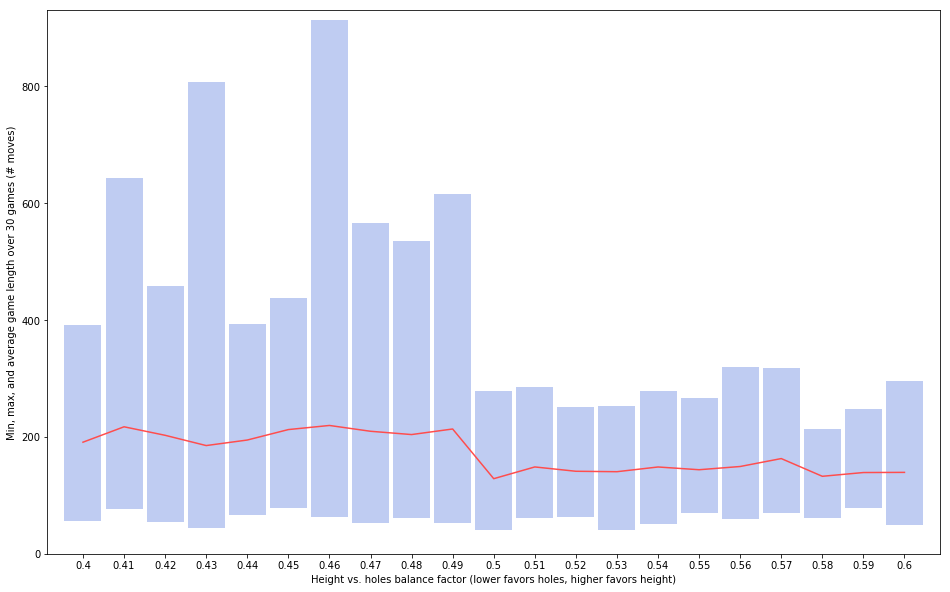

In [16]:
with open("holes-and-height-scan-.4-.6.txt") as f:
    firstLine = f.readline()
    print(firstLine)
    a = np.loadtxt(f,delimiter=",")
X = a[:,1]
avg = a[:,4]
mins = a[:,2]
maxs = a[:,3]

plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 30 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")

width = (max(X) - min(X)) / (len(X)-1)
gap=.001
# Note due to the way plt.bar works we have to pass maxs-mins in for the max value.
# The mins value moves the whole bar up, not just the bottom of the bar.
plt.bar(X, maxs-mins, width-gap, mins, tick_label=[round(f, 2) for f in X], color=(.75, .8, .95))
plt.plot(X, avg, "-", color=(1, .3, .3))
plt.ylim(ymin=0);


Looks like there is a lot of random noise, especially in the max value.  However, there was still a significant decrease between 0.49 and 0.5.  In both graphs, a value of around 0.46-0.48 seems best.

# conclusions
what we learned



# references
* [russell and norvig, 2014] suart russell and peter norvig, AI: a modern approach, publisher, 2014
* https://codemyroad.wordpress.com/2013/04/14/tetris-ai-the-near-perfect-player/

# Code
import code

# code snippets that you want to explain

* single sentence paragraph is kind of worthless
    * single paragraph section also not worth it
* dont break up the flow too much - sections dont matter if it flows well
* tell reader what's in each section at the beginning of the section

